In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping

In [70]:
# 모델 아키택처 생성

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu6', input_shape=(96,96,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu6'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu6'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu6'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu6'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu6'))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_15 (Dropout)        (None, 48, 48, 16)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_16 (Dropout)        (None, 24, 24, 32)       

In [71]:
def rotate_image(image, angle):
    # 이미지 중앙 좌표 계산
    height, width = image.shape[:2]
    center = (width / 2, height / 2)

    # 회전 변환 행렬 생성
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 이미지 회전
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

Data shape: (30592, 96, 96, 3)
Labels: (30592, 4)
[0 1 0 0]


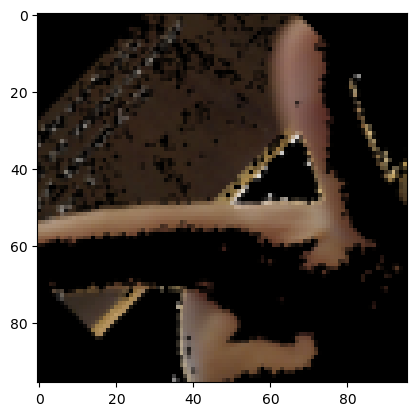

In [72]:
# 학습 데이터 구축

import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

mask_path = "hand_train"

data = []
labels = []

for dty in os.listdir(mask_path):
    dty_path = os.path.join(mask_path, dty)
    if dty == 'rock':
        label = (1,0,0,0)
    elif dty == "scissors":
        label = (0,1,0,0)
    elif dty == 'paper':
        label = (0,0,1,0)
    else:
        label = (0,0,0,1)
        
    for dty2 in os.listdir(dty_path):
        dty2_path = os.path.join(dty_path, dty2)
    
        if os.path.isdir(dty2_path):
            for file in os.listdir(dty2_path):
                file_path = os.path.join(dty2_path, file)

                try:
                    image = cv2.imread(file_path)
                    if image is not None and image.size > 0:
                        # 전처리 코드
                        image = cv2.resize(image, (96,96))   
                        image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # BGR에서 HSV로 변환
                        lower1 = np.array([3, 5, 30])
                        upper1 = np.array([20, 150, 255])
                        lower2 = np.array([160, 5, 30])
                        upper2 = np.array([180, 150, 255])
                        mask1 = cv2.inRange(image_hsv, lower1, upper1)
                        mask2 = cv2.inRange(image_hsv, lower2, upper2)
                        mask = mask1 + mask2
                        image_bgr_masked = cv2.bitwise_and(image, image, mask=mask) # 이미지에 마스크를 적용
                        image = cv2.cvtColor(image_bgr_masked, cv2.COLOR_BGR2RGB) # BGR에서 RGB로 변환

                        # 전처리 종료
                        data.append(image)
                        labels.append(label)
                        
                        if dty != 'no':
                            for i in range(7):
                                angle = (i+1) * 45
                                r_image = rotate_image(image, angle)
  
                                data.append(r_image)
                                labels.append(label)
                        
                except Exception as e:
                    print(flie_path)

data = np.array(data)
labels = np.array(labels)

print("Data shape:",data.shape)
print("Labels:",labels.shape)
indices = np.arange(len(data))

np.random.shuffle(indices)

data = data[indices]
labels = labels[indices]
plt.imshow(data[0], cmap='gray')
print(labels[0])

In [73]:
# train, valid, test 데이터 분리
x_train = data.astype('float32') / 255.0
#x_train = np.expand_dims(x_train, axis=-1)  # 배치 차원 추가

x_test = x_train[28000:]
y_test = labels[28000:]

x_valid = x_train[26000:28000]
y_valid = labels[26000:28000]

x_train = x_train[:26000]
y_train = labels[:26000]

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)


(26000, 96, 96, 3)
(2000, 96, 96, 3)
(2592, 96, 96, 3)
(26000, 4)
(2000, 4)
(2592, 4)


In [74]:
# 파라미터는 자유롭게 조절
hist = model.fit(x_train, y_train, epochs = 15, batch_size = 64, validation_data=(x_valid,y_valid),  callbacks=[early_stopping])

Epoch 1/15
407/407 [==============================] - 33s 77ms/step - loss: 0.7166 - accuracy: 0.6930 - val_loss: 0.3743 - val_accuracy: 0.8700
Epoch 2/15
407/407 [==============================] - 34s 84ms/step - loss: 0.3627 - accuracy: 0.8718 - val_loss: 0.2503 - val_accuracy: 0.9280
Epoch 3/15
407/407 [==============================] - 38s 95ms/step - loss: 0.2595 - accuracy: 0.9102 - val_loss: 0.1954 - val_accuracy: 0.9365
Epoch 4/15
407/407 [==============================] - 50s 123ms/step - loss: 0.1941 - accuracy: 0.9334 - val_loss: 0.1642 - val_accuracy: 0.9470
Epoch 5/15
407/407 [==============================] - 51s 126ms/step - loss: 0.1563 - accuracy: 0.9473 - val_loss: 0.1328 - val_accuracy: 0.9610
Epoch 6/15
407/407 [==============================] - 41s 100ms/step - loss: 0.1368 - accuracy: 0.9533 - val_loss: 0.1562 - val_accuracy: 0.9505
Epoch 7/15
407/407 [==============================] - 66s 163ms/step - loss: 0.1187 - accuracy: 0.9594 - val_loss: 0.1230 - val_accur

In [75]:
loss_and_acc = model.evaluate(x_test, y_test, batch_size=64)
print("Test set Loss and Accuracy")
print(loss_and_acc)

41/41 [==============================] - 1s 18ms/step - loss: 0.0606 - accuracy: 0.9803
Test set Loss and Accuracy
[0.0606328584253788, 0.9803240895271301]


1/1 [==============================] - 0s 17ms/step
Predictions:  [[1.5146944e-05 9.4922906e-01 5.0712533e-02 4.3174416e-05]]


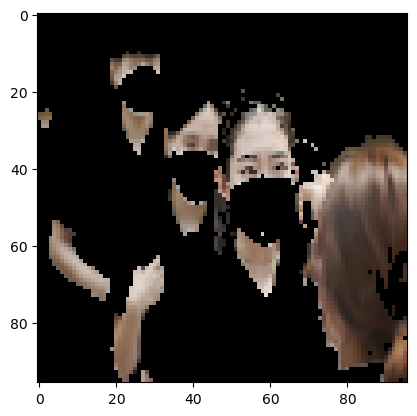

In [84]:
# 원하는 이미지로 테스트
image = cv2.imread('data/mask6.jpg')
image = cv2.resize(image, (96,96))
image = np.array(image)

image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # BGR에서 HSV로 변환
lower1 = np.array([0, 5, 30])
upper1 = np.array([20, 150, 255])
lower2 = np.array([160, 5, 30])
upper2 = np.array([180, 150, 255])
mask1 = cv2.inRange(image_hsv, lower1, upper1)
mask2 = cv2.inRange(image_hsv, lower2, upper2)
mask = mask1 + mask2
image_bgr_masked = cv2.bitwise_and(image, image, mask=mask) # 이미지에 마스크를 적용
image = cv2.cvtColor(image_bgr_masked, cv2.COLOR_BGR2RGB)
plt.imshow(image)

image = image / 255.0  # 정규화 (예: 0-1 범위로 조정)
image = np.expand_dims(image, axis=0)  # 배치 차원 추가
#print(mask.shape)

prediction = model.predict(image)
print("Predictions: ", prediction)

In [77]:
from tensorflow.keras.models import load_model
model.save('rock_RGB_3.h5')

C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [78]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 96, 96, 3)
      yield [data.astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8
converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()
with open('rock_3_int8.tflite','wb') as f:
    f.write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp21scb8a2\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp21scb8a2\assets
C:\Users\user\anaconda3\lib\site-packages\tensorflow\lite\python\convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [79]:
# tflite 모델 테스트

interpreter = tf.lite.Interpreter(model_path="rock_3_int8.tflite")
interpreter.allocate_tensors()

# Print information about the model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_conv2d_15_input:0', 'index': 0, 'shape': array([ 1, 96, 96,  3]), 'shape_signature': array([-1, 96, 96,  3]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0039215669967234135, -128), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 29, 'shape': array([1, 4]), 'shape_signature': array([-1,  4]), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128]), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


(1, 96, 96, 3)
[[ -56   52 -126 -127]]


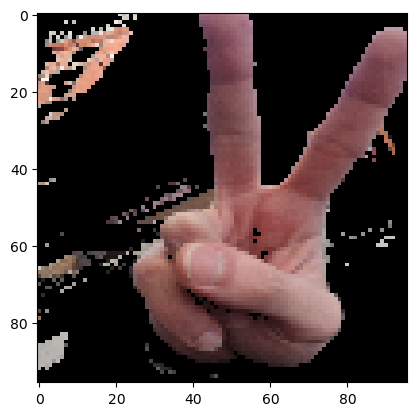

In [94]:
# 모델의 입력 크기 가져오기
input_shape = input_details[0]['shape'][1:3]

# 테스트할 이미지 로드 및 전처리
image_path = "data/hand10.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, tuple(input_shape))

image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # BGR에서 HSV로 변환
lower1 = np.array([0, 5, 30])
upper1 = np.array([20, 150, 255])
lower2 = np.array([160, 5, 30])
upper2 = np.array([180, 150, 255])
mask1 = cv2.inRange(image_hsv, lower1, upper1)
mask2 = cv2.inRange(image_hsv, lower2, upper2)
mask = mask1 + mask2
image_bgr_masked = cv2.bitwise_and(image, image, mask=mask) # 이미지에 마스크를 적용
image = cv2.cvtColor(image_bgr_masked, cv2.COLOR_BGR2RGB)
plt.imshow(image)
image = np.expand_dims(image, axis=0)
image = image - 128
image = image.astype(np.int8)
print(image.shape)


# 모델에 입력 데이터 제공
interpreter.set_tensor(input_details[0]['index'], image)

# 추론 실행
interpreter.invoke()

scale, zero_point = output_details[0]["quantization"]

# 모델의 출력 받기
output_data = interpreter.get_tensor(output_details[0]['index'])
#output_data = ((output_data - zero_point) * scale).astype(np.float32)
print(output_data)